Cargamos datos

In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np

warnings.filterwarnings("ignore")

In [107]:
df = pd.read_csv('../../datamarts/final_dataframe.tsv', sep='\t')


In [108]:
df.head()

,Timestamp,NUMERO,CCAA1,CCAA2,CCAA3,CCAA4,CCAA5,CCAA6,CCAA7,CCAA8,...,EDUCACIÓN_NO_FORMAL_104,RESTAURACIÓN_111,ALOJAMIENTO_112,CUIDADOS_PERSONALES_121,EFECTOS_PERSONALES_123,PROTECCIÓN_SOCIAL_124,SEGUROS_125,SERVICIOS_FINANCIEROS_126,OTROS_SERVICIOS_127,REMESAS_128
0,2016-01-01T00:00:00,1,0,0,0,0,0,0,1,0,...,NaN,668.274699,NaN,98.935487,0.300641,NaN,32.562055,NaN,1.535195,NaN
1,2016-01-01T00:00:00,47,0,0,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,27.276033,NaN,NaN,NaN
2,2016-01-01T00:00:00,53,0,0,0,0,0,0,1,0,...,NaN,111.840309,NaN,NaN,NaN,NaN,47.234176,NaN,NaN,NaN
3,2016-01-01T00:00:00,67,0,0,0,0,0,0,1,0,...,NaN,4.016997,NaN,NaN,3.614237,NaN,NaN,NaN,NaN,NaN
4,2016-01-01T00:00:00,68,0,0,0,0,0,0,1,0,...,NaN,319.334544,159.860498,73.549838,NaN,NaN,33.530006,NaN,66.724382,NaN


In [109]:
# 2. Columnas de entrada y salida
output_cols = [c for c in df.columns if c.endswith(tuple(f"_{i}" for i in range(11,129)))]
input_cols  = [c for c in df.columns if c not in output_cols + ["NUMERO", "Timestamp", "CCAA12", "PENSIO", "GASTOT_MENSUAL"]]

# 3. Extraer matrices"
X = df[input_cols].values                            
y = df[output_cols].values                           


In [110]:
# 1. Eliminar filas con NaNs en X
mask_X = ~np.isnan(X).any(axis=1)
X_clean = X[mask_X]
y_clean = y[mask_X, :]

Normalizamos

In [111]:
# 2. Escalar X
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_clean)

# 3. Escala de y (media y std ignorando NaNs por columna)
y_means = np.nanmean(y_clean, axis=0)
y_stds  = np.nanstd(y_clean,  axis=0)
y_scaled = (y_clean - y_means) / y_stds

# Justo tras calcular y_means y y_stds, filtra salidas constantes:
valid_outputs = y_stds != 0
if not valid_outputs.all():
    cols = np.array(output_cols)[~valid_outputs]
    print("Eliminando columnas constantes o invalidas en y:", cols.tolist())

In [112]:
# 4. División en train/validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

In [113]:
# Filtramos también el modelo y nuestros conjuntos:
output_cols = list(np.array(output_cols)[valid_outputs])
y_clean = y_clean[:, valid_outputs]
y_scaled = y_scaled[:, valid_outputs]

In [114]:
# 5. Tensores y DataLoaders
batch_size = 64
train_ds = TensorDataset(
    torch.from_numpy(X_tr).float(),
    torch.from_numpy(y_tr).float()
)
val_ds   = TensorDataset(
    torch.from_numpy(X_val).float(),
    torch.from_numpy(y_val).float()
)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)


In [ ]:
# 7. Definición del modelo
input_dim = X_tr.shape[1]   # debería ser 56
output_dim = y_tr.shape[1]  # debería ser 45

input_dim, output_dim

(56, 45)

### Digital Twin

In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import matplotlib.pyplot as plt


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SingleOutputModel(nn.Module):
    """
    Small MLP that predicts one output, with positive enforcement via Softplus.
    """
    def __init__(self, in_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Softplus()
        )

    def forward(self, x):
        # x: [batch, in_dim]
        return self.net(x)  # output: [batch, 1]



In [118]:

class EnsembleDigitalTwin(nn.Module):
    """
    Wraps 45 independent SingleOutputModel instances,
    one per output category. Forward pass runs all submodels.
    """
    def __init__(self, in_dim: int = 57, n_outputs: int = 45):
        super().__init__()
        self.submodels = nn.ModuleList(
            [SingleOutputModel(in_dim) for _ in range(n_outputs)]
        )

    def forward(self, x):
        # x: [batch, in_dim]
        outputs = [sub(x) for sub in self.submodels]  # list of [batch,1]
        return torch.cat(outputs, dim=1)               # [batch, n_outputs]

In [129]:
def configure_optimizers(model: EnsembleDigitalTwin, lr=5e-4, weight_decay=5e-4, eps=1e-8):
    """
    Para un EnsembleDigitalTwin con n_outputs cabezas, devuelve una lista
    de optimizadores AdamW, uno por cada submodelo.
    """
    return [
        AdamW(sub.parameters(), lr=lr, weight_decay=weight_decay, eps=eps)
        for sub in model.submodels
    ]


In [130]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ensemble = EnsembleDigitalTwin(in_dim=input_dim, n_outputs=output_dim)


In [134]:
import torch
import torch.nn as nn
from sklearn.metrics import r2_score

def train_ensemble(model, train_loader, val_loader, device,
                   epochs=100, grad_clip=1.0, patience=20):
    model.to(device)
    optimizers = configure_optimizers(model)
    best_val, wait = float('inf'), 0
    train_losses, val_losses = [], []
    val_r2s = []

    for epoch in range(1, epochs+1):
        # -------- Training --------
        model.train()
        epoch_train_loss = 0.0
        epoch_train_count = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)  # [B, in_dim], [B, n_out]

            # Para cada cabeza / salida i
            for i, (sub, opt) in enumerate(zip(model.submodels, optimizers)):
                mask = ~torch.isnan(yb[:, i])
                if not mask.any():
                    continue

                opt.zero_grad()
                preds_i = sub(xb).squeeze(1)         # [B]
                target_i = yb[:, i]                  # [B]
                se = (preds_i[mask] - target_i[mask]) ** 2
                loss_i = se.mean()
                loss_i.backward()
                nn.utils.clip_grad_norm_(sub.parameters(), grad_clip)
                opt.step()

                epoch_train_loss += se.sum().item()
                epoch_train_count += mask.sum().item()

        train_loss = epoch_train_loss / epoch_train_count if epoch_train_count else float('nan')
        train_losses.append(train_loss)

        # -------- Validation --------
        model.eval()
        epoch_val_loss = 0.0
        epoch_val_count = 0

        # Para R2
        y_true_all = []
        y_pred_all = []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)  # [B, n_out]

                for i in range(outputs.size(1)):
                    mask = ~torch.isnan(yb[:, i])
                    if not mask.any():
                        continue
                    # MSE
                    se = (outputs[mask, i] - yb[mask, i]) ** 2
                    epoch_val_loss += se.sum().item()
                    epoch_val_count += mask.sum().item()
                    # recopilar para R2
                    y_true_all.append(yb[mask, i].cpu().numpy())
                    y_pred_all.append(outputs[mask, i].cpu().numpy())

        val_loss = epoch_val_loss / epoch_val_count if epoch_val_count else float('nan')
        val_losses.append(val_loss)

        # Calcular R2
        if y_true_all:
            y_true_all = np.concatenate(y_true_all)
            y_pred_all = np.concatenate(y_pred_all)
            val_r2 = r2_score(y_true_all, y_pred_all)
        else:
            val_r2 = float('nan')
        val_r2s.append(val_r2)

        # Early stopping & checkpoint
        if not torch.isnan(torch.tensor(val_loss)) and val_loss < best_val:
            best_val, wait = val_loss, 0
            torch.save(model.state_dict(), 'ensemble_digital_twin.pth')
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val R2: {val_r2:.4f}")

    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_r2s': val_r2s
    }


In [132]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score

def train_ensemble(model, train_loader, val_loader, device,
                   epochs=100, grad_clip=1.0, patience=20):
    model.to(device)
    optimizers = configure_optimizers(model)  # lista de AdamW, uno por submodelo
    best_val, wait = float('inf'), 0

    for epoch in range(1, epochs+1):
        # --- Training ---
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            # un paso de optimización por cabeza
            for i, (sub, opt) in enumerate(zip(model.submodels, optimizers)):
                mask = ~torch.isnan(yb[:, i])
                if not mask.any(): 
                    continue
                opt.zero_grad()
                preds_i = sub(xb).squeeze(1)
                loss_i = ((preds_i[mask] - yb[mask, i])**2).mean()
                loss_i.backward()
                nn.utils.clip_grad_norm_(sub.parameters(), grad_clip)
                opt.step()

        # --- Validation ---
        model.eval()
        # acumuladores de MSE por cabeza
        val_se_sum = [0.0]*len(model.submodels)
        val_count  = [0]*len(model.submodels)

        # para R2 global
        y_true_all, y_pred_all = [], []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)  # [B, n_out]
                for i in range(outputs.size(1)):
                    mask = ~torch.isnan(yb[:, i])
                    if not mask.any(): 
                        continue
                    se = (outputs[mask, i] - yb[mask, i])**2
                    val_se_sum[i] += se.sum().item()
                    val_count[i]  += mask.sum().item()

                    # recoger para R2
                    y_true_all.append(yb[mask, i].cpu().numpy())
                    y_pred_all.append(outputs[mask, i].cpu().numpy())

        # calcular mse y r2 por cabeza
        val_mse_per_head = [
            (val_se_sum[i] / val_count[i]) if val_count[i]>0 else np.nan
            for i in range(len(model.submodels))
        ]
        # r2 global
        y_true_all = np.concatenate(y_true_all) if y_true_all else np.array([])
        y_pred_all = np.concatenate(y_pred_all) if y_pred_all else np.array([])
        val_r2 = r2_score(y_true_all, y_pred_all) if y_true_all.size else np.nan

        # Early stopping global (puedes usar mse media de todas las cabezas)
        global_val_mse = np.nanmean(val_mse_per_head)
        if global_val_mse < best_val:
            best_val, wait = global_val_mse, 0
            torch.save(model.state_dict(), 'ensemble_digital_twin.pth')
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        # --- Logging ---
        head_losses_str = ", ".join(f"{mse:.4f}" 
                                   for mse in val_mse_per_head)
        print(f"Epoch {epoch:03d} | Val R2: {val_r2:.4f} | Val MSE heads: [{head_losses_str}]")

    # devolver modelo entrenado
    return model


## Sin dropout

In [135]:
history = train_ensemble(ensemble, train_loader, val_loader, device, epochs=100)

Epoch 001 | Train Loss: 0.8796 | Val Loss: 0.9189 | Val R2: 0.1101
Epoch 002 | Train Loss: 0.8741 | Val Loss: 0.9165 | Val R2: 0.1124
Epoch 003 | Train Loss: 0.8703 | Val Loss: 0.9174 | Val R2: 0.1116
Epoch 004 | Train Loss: 0.8666 | Val Loss: 0.9160 | Val R2: 0.1130


KeyboardInterrupt: 

## Con dropout

In [124]:
history = train_ensemble(ensemble, train_loader, val_loader, device, epochs=100)


Epoch 001 | Train Loss: 0.8501 | Val Loss: 0.9172 | Val R2: 0.1117
Epoch 002 | Train Loss: 0.8470 | Val Loss: 0.9196 | Val R2: 0.1094
Epoch 003 | Train Loss: 0.8443 | Val Loss: 0.9198 | Val R2: 0.1093
Epoch 004 | Train Loss: 0.8414 | Val Loss: 0.9199 | Val R2: 0.1092
Epoch 005 | Train Loss: 0.8395 | Val Loss: 0.9211 | Val R2: 0.1080
Epoch 006 | Train Loss: 0.8365 | Val Loss: 0.9215 | Val R2: 0.1076
Epoch 007 | Train Loss: 0.8336 | Val Loss: 0.9227 | Val R2: 0.1065
Epoch 008 | Train Loss: 0.8315 | Val Loss: 0.9236 | Val R2: 0.1056
Epoch 009 | Train Loss: 0.8284 | Val Loss: 0.9240 | Val R2: 0.1052
Epoch 010 | Train Loss: 0.8260 | Val Loss: 0.9239 | Val R2: 0.1053
Epoch 011 | Train Loss: 0.8237 | Val Loss: 0.9252 | Val R2: 0.1041
Epoch 012 | Train Loss: 0.8211 | Val Loss: 0.9279 | Val R2: 0.1014
Epoch 013 | Train Loss: 0.8193 | Val Loss: 0.9282 | Val R2: 0.1011


KeyboardInterrupt: 

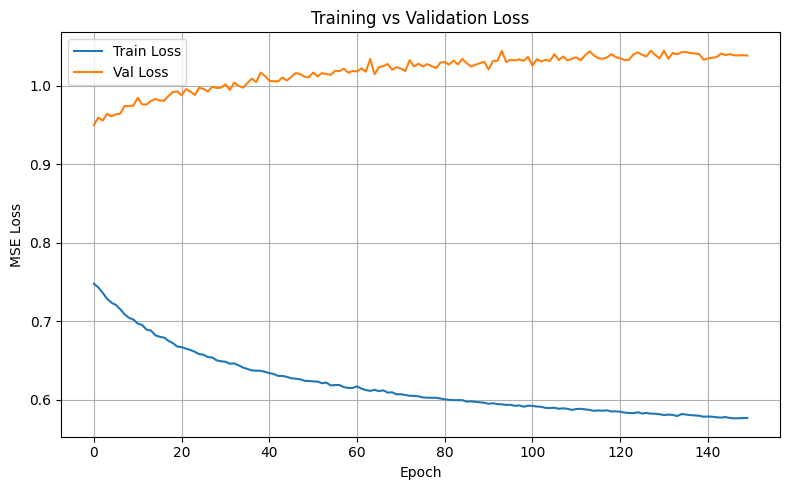

In [ ]:

# 1) Loss curves
plt.figure(figsize=(8,5))
plt.plot(history['train_losses'], label='Train Loss')
plt.plot(history['val_losses'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# After training, save final model state añade que guarde el escalador de X y los parámetros de salida en un.pt
torch.save({
    'model_state_dict': ensemble.state_dict(),
    'scaler_X': scaler_X,
    'y_means': y_means,
    'y_stds': y_stds,
    'output_cols': output_cols
}, 'ensemble_digital_twin_final.pt')

## Modelo 2

In [53]:
class DigitalTwinModel(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
        )
        # Una pequeña cabeza por salida
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(256, 64),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(64, 1),
                nn.Softplus()
            ) for _ in range(out_dim)
        ])

    def forward(self, x):
        feat = self.backbone(x)
        outs = [head(feat) for head in self.heads]
        return torch.cat(outs, dim=1)


In [59]:
# -----------------------------
# Weight Initialization
# -----------------------------
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [72]:
# -----------------------------
# Data Loading & Preprocessing
# -----------------------------

def load_data(tsv_path: str):
    df = pd.read_csv(tsv_path, sep='\t')
    df.fillna(0, inplace=True)
    # Identify output columns ending with _11.._128
    output_cols = [c for c in df.columns if any(c.endswith(f"_{i}") for i in range(11,129))]
    # Exclude auxiliaries
    excluded = set(output_cols + ['GASTOT_MENSUAL','NUMERO','CCAA', 'Timestamp'])
    feature_cols = [c for c in df.columns if c not in excluded]
    X = df[feature_cols].values.astype(np.float32)
    y = df[output_cols].values.astype(np.float32)
    return X, y, feature_cols, output_cols

def preprocess(X: np.ndarray, y: np.ndarray):
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y)

    return X_scaled, y_scaled, scaler_X, scaler_y

In [73]:
tsv_path = '../../datamarts/final_dataframe.tsv'
X, y, feature_cols, output_cols = load_data(tsv_path)
X_scaled, y_scaled, scaler_X, scaler_y = preprocess(X, y)

In [74]:
# -----------------------------
# DataLoader Creation
# -----------------------------

def get_loaders(X, y, batch_size=64, val_frac=0.2, seed=42):
    X_tr, X_val, y_tr, y_val = train_test_split(
        X, y, test_size=val_frac, random_state=seed
    )
    train_ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
    val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    return train_loader, val_loader


In [75]:
train_loader, val_loader = get_loaders(X_scaled, y_scaled, batch_size=64)

model = DigitalTwinModel(in_dim=X_scaled.shape[1], out_dim=y_scaled.shape[1])

In [76]:
# -----------------------------
# Training Function
# -----------------------------
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import Adam
from sklearn.metrics import mean_squared_error

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
    epochs: int = 300,
    lr: float = 1e-4,
    weight_decay: float = 1e-4,
    patience: int = 15
):
    model.to(device)
    model.apply(init_weights)

    optimizer = Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True
    )
    criterion = nn.MSELoss()

    best_val = float('inf')
    wait = 0
    train_losses, val_losses = [], []

    for epoch in range(1, epochs+1):
        # Training step
        model.train()
        running_train = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_train += loss.item() * xb.size(0)
        train_loss = running_train / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation step
        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                running_val += criterion(model(xb), yb).item() * xb.size(0)
        val_loss = running_val / len(val_loader.dataset)
        val_losses.append(val_loss)

        # Scheduler + Early Stopping
        scheduler.step(val_loss)
        if val_loss < best_val:
            best_val = val_loss
            wait = 0
            torch.save(model.state_dict(), 'improved_twin_best.pth')
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        if epoch == 1 or epoch % 20 == 0:
            print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Save final state
    torch.save(model.state_dict(), 'improved_twin_final.pth')
    return train_losses, val_losses

In [77]:
train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs=300,
    lr=1e-4,
    weight_decay=1e-4,
    patience=100
)

Epoch 001 | Train Loss: 1.0098 | Val Loss: 0.9455
Epoch 020 | Train Loss: 0.9265 | Val Loss: 0.9147
Epoch 040 | Train Loss: 0.9223 | Val Loss: 0.9117
Epoch 060 | Train Loss: 0.9197 | Val Loss: 0.9104
Epoch 080 | Train Loss: 0.9183 | Val Loss: 0.9096
Epoch 100 | Train Loss: 0.9179 | Val Loss: 0.9091
Epoch 120 | Train Loss: 0.9175 | Val Loss: 0.9095


KeyboardInterrupt: 

In [ ]:
checkpoint = {
        'model_state_dict': model.state_dict(),
        'scaler_X': scaler_X,
        'scaler_y': scaler_y
    }
torch.save(checkpoint, 'improved_digital_twin.pt')
print('Checkpoint saved to improved_digital_twin.pt')


IndentationError: unexpected indent (1755701975.py, line 6)

In [79]:
# -----------------------------
# Plotting Utilities
# -----------------------------

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses,   label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_parity(model, val_loader, device):
    y_true, y_pred = [], []
    model.to(device).eval()
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            y_true.append(yb.numpy())
            y_pred.append(model(xb).cpu().numpy())
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    plt.figure(figsize=(6,6))
    plt.scatter(y_true.flatten(), y_pred.flatten(), s=5, alpha=0.3)
    m = min(y_true.min(), y_pred.min())
    M = max(y_true.max(), y_pred.max())
    plt.plot([m, M], [m, M], 'k--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Parity: Actual vs Predicted')
    plt.tight_layout()
    plt.show()

In [80]:
plot_losses(train_losses, val_losses)

NameError: name 'train_losses' is not defined

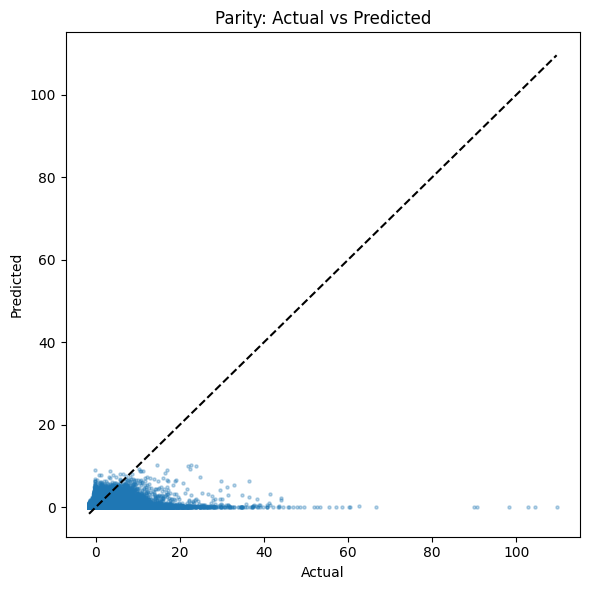

In [81]:
plot_parity(model, val_loader, device)

### Con atencion

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ExplicationAttentionMechanism(nn.Module):
    def __init__(self, number_of_characteristics, dropout=0.1):
        super().__init__()
        self.hidden_size = number_of_characteristics
        self.to_q = nn.Linear(1, self.hidden_size, bias=True)
        self.to_k = nn.Linear(1, self.hidden_size, bias=True)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(number_of_characteristics)

    def forward(self, x):
        X = x.unsqueeze(-1)  # (batch, features, 1)
        Q = self.to_q(X)     # (batch, features, hidden)
        K = self.to_k(X)     # (batch, features, hidden)
        scores = torch.matmul(Q, K.transpose(1, 2)) / math.sqrt(self.hidden_size)  # (batch, features, features)
        attn = F.softmax(scores, dim=-1)  # atención sobre features
        attn = self.dropout(attn)
        importance = attn.sum(dim=1)  # (batch, features)
        return self.norm(importance)

class AttentionDigitalTwinModel(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.attn = ExplicationAttentionMechanism(in_dim)

        self.backbone = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(256, 64),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(64, 1),
                nn.Softplus()
            ) for _ in range(out_dim)
        ])

    def forward(self, x):
        # Atenuar input
        attention_weights = self.attn(x)
        x_attended = x * attention_weights  # Recalibrar input
        feat = self.backbone(x_attended)
        outputs = [head(feat) for head in self.heads]
        return torch.cat(outputs, dim=1)


In [82]:
# ------------------------------------
# Weight Initialization
# ------------------------------------
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [84]:
# ------------------------------------
# Training Function
# ------------------------------------
def train_attention_model(model, train_loader, val_loader, device,
                          epochs=200, lr=1e-4, weight_decay=1e-4, patience=15):
    model.to(device)
    model.apply(init_weights)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    criterion = nn.MSELoss()
    best_val, wait = float('inf'), 0
    train_losses, val_losses = [], []

    for epoch in range(1, epochs+1):
        model.train(); run_train = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            run_train += loss.item() * xb.size(0)
        train_loss = run_train / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval(); run_val = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                run_val += criterion(model(xb), yb).item() * xb.size(0)
        val_loss = run_val / len(val_loader.dataset)
        val_losses.append(val_loss)

        scheduler.step(val_loss)
        if val_loss < best_val:
            best_val, wait = val_loss, 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'scaler_X': scaler_X,
                'scaler_y': scaler_y
            }, 'attention_digital_twin_best.pt')
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        if epoch == 1 or epoch % 20 == 0:
            print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    torch.save({
        'model_state_dict': model.state_dict(),
        'scaler_X': scaler_X,
        'scaler_y': scaler_y
    }, 'attention_digital_twin_final.pt')
    return train_losses, val_losses


In [87]:
model = AttentionDigitalTwinModel(in_dim=X.shape[1], out_dim=y.shape[1])
train_losses, val_losses = train_attention_model(
    model, train_loader, val_loader, device
)

Epoch 001 | Train Loss: 1.0058 | Val Loss: 0.9649
Epoch 020 | Train Loss: 0.9279 | Val Loss: 0.9184
Epoch 040 | Train Loss: 0.9203 | Val Loss: 0.9126
Epoch 060 | Train Loss: 0.9166 | Val Loss: 0.9099
Epoch 080 | Train Loss: 0.9145 | Val Loss: 0.9086
Epoch 100 | Train Loss: 0.9134 | Val Loss: 0.9081
Epoch 120 | Train Loss: 0.9132 | Val Loss: 0.9085
Early stopping at epoch 125


In [85]:
# ------------------------------------

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses,   label='Val')
    plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Loss Curves'); plt.legend(); plt.grid(True); plt.show()

def plot_parity(model, val_loader, device):
    y_true, y_pred = [], []
    model.to(device).eval()
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            y_true.append(yb.numpy()); y_pred.append(model(xb).cpu().numpy())
    y_true, y_pred = np.vstack(y_true), np.vstack(y_pred)
    plt.figure(figsize=(6,6))
    plt.scatter(y_true.flatten(), y_pred.flatten(), s=5, alpha=0.3)
    m, M = y_true.min(), y_true.max()
    plt.plot([m, M],[m, M],'k--'); plt.xlabel('Actual'); plt.ylabel('Pred'); plt.show()


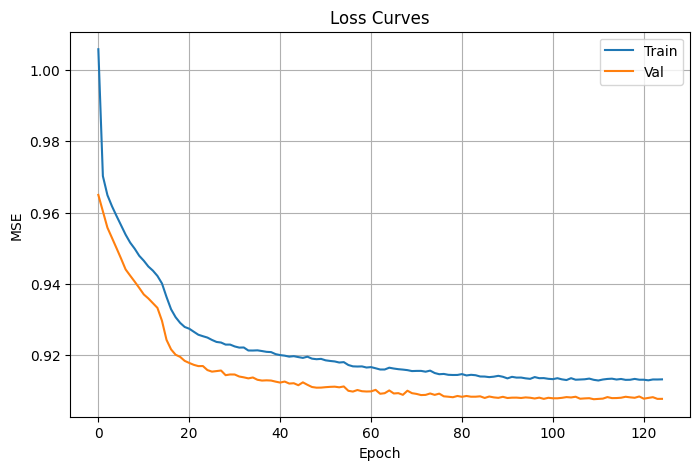

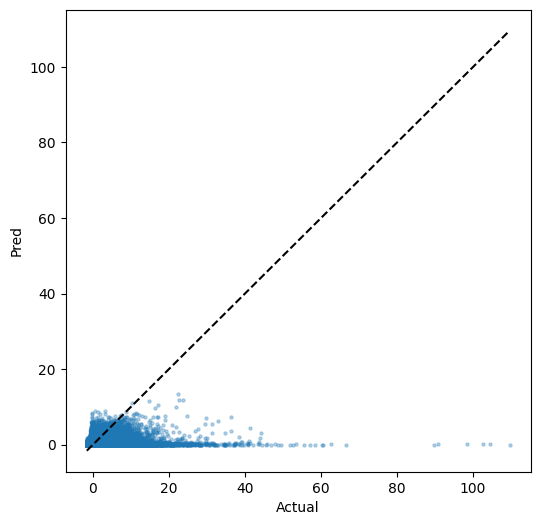

In [88]:
plot_losses(train_losses, val_losses)
plot_parity(model, val_loader, device)



In [90]:
# Save checkpoint with scalers
checkpoint = {
    'model_state_dict': model.state_dict(),
    'scaler_X': scaler_X,
    'scaler_y': scaler_y
    }

torch.save(checkpoint, 'attention_digital_twin_complete.pt')
print('Saved full checkpoint as attention_digital_twin_complete.pt')

Saved full checkpoint as attention_digital_twin_complete.pt


In [93]:
import torch
import numpy as np
import pandas as pd

# 1) Carga del checkpoint completo
ckpt = torch.load('attention_digital_twin_complete.pt', map_location='cpu')
scaler_X = ckpt['scaler_X']
scaler_y = ckpt['scaler_y']
state_dict = ckpt['model_state_dict']

# 2) Reconstrucción de la arquitectura
in_dim = scaler_X.mean_.shape[0]
out_dim = scaler_y.mean_.shape[0]
model = AttentionDigitalTwinModel(in_dim=in_dim, out_dim=out_dim)
model.load_state_dict(state_dict)
model.eval()

# 3) Carga de tu DataFrame y selección de un ejemplo

# Asegúrate de que 'feature_cols' está definido en el mismo orden
feature_cols = [
    "CAPROV","TAMAMU","DENSIDAD","SUPERF","AGUACALI","CALEF","ZONARES","REGTEN",
    "NUMOCU","NUMACTI","NUMPERI","NUMESTU","NADUL_MAS","NADUL_FEM","NNINO_FEM",
    "NNINO_MAS","OCUSP","EDADSP","NACION_ESP","EDUC_SUPERIOR","CAPROP","CAJENA",
    "DISPOSIOV","IMPEXAC","Tmax_max","Tmin_min","Tasa_Paro","Inflacion","Tipo_Interes"
]

# Elige un índice, por ejemplo el primero
idx = 0
sample = df.iloc[idx][feature_cols].values.astype(float)

# 4) Escalado y predicción
X = sample.reshape(1, -1)
X_scaled = scaler_X.transform(X)
with torch.no_grad():
    y_scaled = model(torch.tensor(X_scaled, dtype=torch.float32)).cpu().numpy()

# 5) Desescalado de la salida
y_pred = scaler_y.inverse_transform(y_scaled)

# 6) Mostrar resultados
# Si tienes una lista de códigos de salida:
output_cols = [
    11,12,21,22,31,32,41,42,43,44,
    45,51,52,53,54,55,56,61,62,63,
    71,72,73,81,82,83,91,92,93,94,
    95,96,101,102,103,104,111,112,
    121,123,124,125,126,127,128
]

result = {code: float(val) for code, val in zip(output_cols, y_pred.flatten())}
print(f"Predicción para fila {idx}:")
for code, val in result.items():
    print(f"  Categoría {code}: {val:.2f}")


Predicción para fila 0:
  Categoría 11: 336.32
  Categoría 12: 24.03
  Categoría 21: 16.70
  Categoría 22: 26.95
  Categoría 31: 78.42
  Categoría 32: 26.27
  Categoría 41: 62.70
  Categoría 42: 478.95
  Categoría 43: 19.85
  Categoría 44: 63.42
  Categoría 45: 95.11
  Categoría 51: 19.83
  Categoría 52: 8.64
  Categoría 53: 19.00
  Categoría 54: 4.63
  Categoría 55: 5.97
  Categoría 56: 42.99
  Categoría 61: 53.29
  Categoría 62: 30.31
  Categoría 63: 3.08
  Categoría 71: 88.09
  Categoría 72: 164.33
  Categoría 73: 24.29
  Categoría 81: 0.45
  Categoría 82: 6.68
  Categoría 83: 63.24
  Categoría 91: 13.03
  Categoría 92: 2.25
  Categoría 93: 31.43
  Categoría 94: 37.03
  Categoría 95: 15.03
  Categoría 96: 19.68
  Categoría 101: 10.44
  Categoría 102: 7.82
  Categoría 103: 13.16
  Categoría 104: 2.56
  Categoría 111: 187.23
  Categoría 112: 26.38
  Categoría 121: 60.26
  Categoría 123: 11.49
  Categoría 124: 5.13
  Categoría 125: 80.52
  Categoría 126: 1.14
  Categoría 127: 12.84
  C